# Prototype for analytical model classes

The aim of this worksheet is to experiment and design a set of classes for expressing analytical models for well test interpretation. The general idea is that there should be a parent generic class and a set of derived classes allowing to avoid repeating code.

In this first prototype, I consider only the generic parent class and two daughter classes.

Nov. 7 2019 - P. Renard

Nov. 20 2019 - N. Dutler (noflow, consthead incl. laplace)

Dec. 14 2019 - N. Dutler (Cooper-Bredehoeft-Papadopulos)

Dec. 30 2019 - N. Dutler (Report, self operator includes now all solutions and statistics from fit)

Jan. 10 2020 - N. Dutler (Jacob-Lohman, Demo Theis, change preprocessing to class)

Feb. 10 2020 - N. Dutler (GRF)


In [1]:
%matplotlib inline
import sys
sys.path.append("..")
import openhytest as ht
import mpmath as mp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

In [3]:
# Read a data set to test ideas
df1 = pd.read_csv('../data/ths_ds1.txt', header=None,sep=" ",names=['t','s'], dtype={'t': 'float64', 's': 'float64'})
df2 = pd.read_csv('../data/thn_ds1.txt', header=None,sep=" ",names=['t','s'], dtype={'t': 'float64', 's': 'float64'})
df3 = pd.read_csv('../data/thc_ds1.txt', header=None,sep=" ",names=['t','s'], dtype={'t': 'float64', 's': 'float64'})
df4 = pd.read_csv('../data/pca_ds1.txt', header=None,sep=" ",names=['t','s'], dtype={'t': 'float64', 's': 'float64'})
df5 = pd.read_csv('../data/jlq_ds1.txt', header=None,sep=" ",names=['t','q'], dtype={'t': 'float64', 'q': 'float64'})
df6 = pd.read_csv('../data/tmc_ds1.txt', header=None,sep="  ",names=['t','q'], dtype={'t': 'float64', 'q': 'float64'})
df7 = pd.read_csv('../data/tmr_ds1.txt', header=None,sep=" ",names=['t','s'], dtype={'t': 'float64', 's': 'float64'})

/Users/nathan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys


Below is the part where the classes are defined in order to test the concept.

The first thing is to define a generic class AnalyticalModels of analytical models that should contain all the generic functionalities.  Then, we derive two examples of daughter classes: the theis and theis_noflow models. 

The theis_noflow model is wrong (wrong equations and parametrizations and needs to be corrected), but the principle seems to work.

The next steps would be to implement:
- the fit function
- one or a pair of examples with laplace domain solution


# How to create a type curve

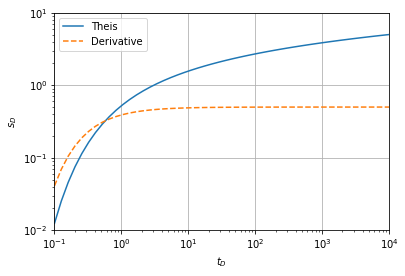

In [12]:
abaque = ht.Theis()
abaque.plot_typecurve()


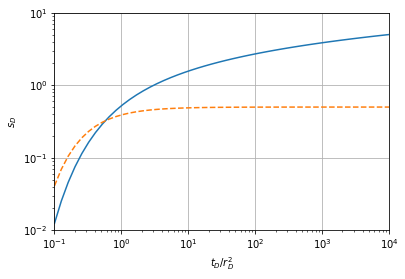

In [13]:
td = np.logspace(-1, 4)
sdn = abaque._laplace_drawdown(td, 'dehoog')
sd = list(sdn)
plt.loglog(td, sd)
#dev = ht.ldiffs(pd.DataFrame({'td':td, 'sd':sd}))
ddn = abaque._laplace_drawdown_derivative(td, 'dehoog')
dd = list(ddn)
plt.xlabel('$t_D / r_D^2$')
plt.ylabel('$s_D$')
plt.plot(td,dd, '--')
plt.xlim((1e-1, 1e4))
plt.ylim((1e-2, 10))
plt.grid('True')

In [14]:
sd2 = abaque.dimensionless(td)
residual = sd-sd2

mr = np.mean(residual) #mean resiudal
print(mr)
sr = 2 * np.std(residual) #standard deviation
print(sr)
rms = np.sqrt(np.mean(residual**2))
print(rms)

4.0733031747911e-12
6.55366209792671e-12
5.22775482183447e-12


In [15]:
dd2 = abaque.dimensionless_logderivative(td)
residual2 = dd-dd2

mr2 = np.mean(residual2) #mean resiudal
print(mr2)
sr2 = 2 * np.std(residual2) #standard deviation
print(sr2)
rms2 = np.sqrt(np.mean(residual2**2))
print(rms2)

5.43991084817064e-13
1.06438262595789e-12
7.6102161202603e-13


# How to adjust a Theis model using guess_params and the fit function

estimated parameter vector: [  1.70038569 341.82452507]


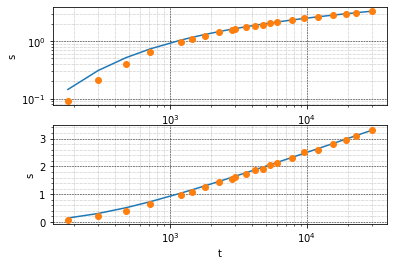

T =  0.0014965736386863039 m2/s
S =  1.838230592225941e-05 -
Ri =  3125.64516579519 m


In [3]:
apaque= ht.Theis(Q=1.3888e-2, r=250, df=df1)
p = apaque.guess_params()
print("estimated parameter vector:",p)
apaque.trial()

`ftol` termination condition is satisfied.
Function evaluations 13, initial cost 3.2141e-02, final cost 8.4643e-03, first-order optimality 2.18e-10.
[  1.78563637 412.12162662]


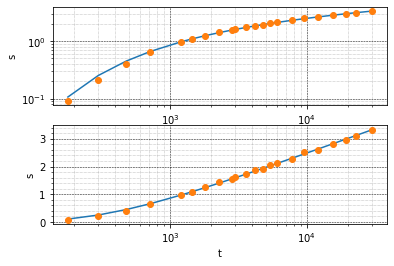

T =  0.0014251235274012491 m2/s
S =  2.1104574206023773e-05 -
Ri =  2846.613998659661 m


In [4]:
p = apaque.fit()
print(p)
apaque.trial()

`ftol` termination condition is satisfied.
Function evaluations 4, initial cost 8.4643e-03, final cost 8.4643e-03, first-order optimality 7.37e-10.


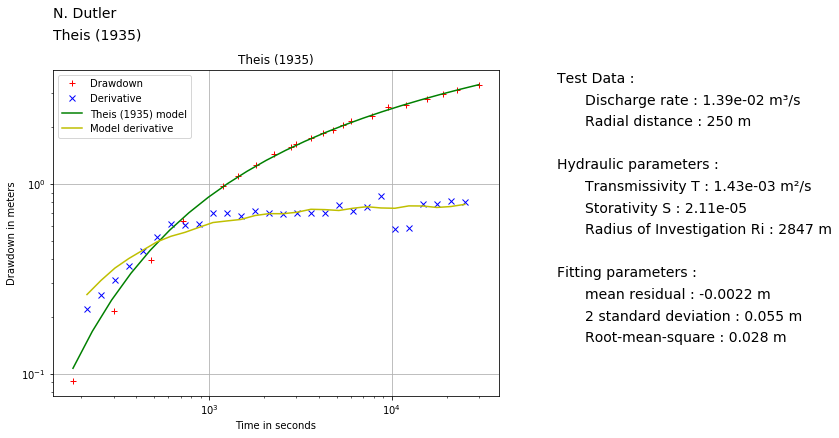

In [5]:
apaque.rpt(author='N. Dutler', filetype='png')

# Moving to no flow model

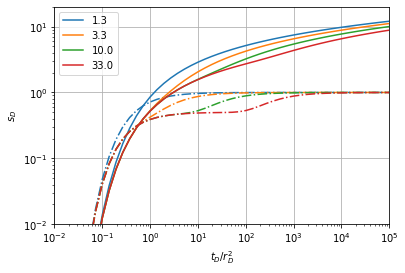

In [19]:
model = ht.Theis_noflow(Rd=33)
model.plot_typecurve()

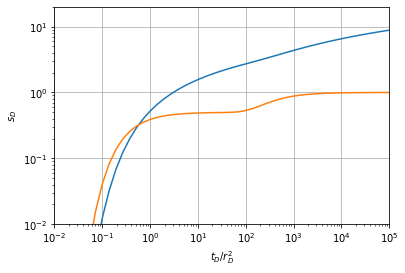

In [20]:
td = np.logspace(-2, 5)
sdn = model._laplace_drawdown(td, 'dehoog')
sd = list(sdn)
plt.loglog(td, sd)
ddn = model._laplace_drawdown_derivative(td, 'dehoog')
dd = list(ddn)
plt.loglog(td, dd)
plt.xlabel('$t_D / r_D^2$')
plt.ylabel('$s_D$')
plt.xlim((1e-2, 1e5))
plt.ylim((1e-2, 20))
plt.grid('True')

In [21]:
sd2 = model.dimensionless(td)
residual = sd-sd2

mr = np.mean(residual) #mean resiudal
print(mr)
sr = 2 * np.std(residual) #standard deviation
print(sr)
rms = np.sqrt(np.mean(residual**2))
print(rms)

5.66010173443643e-12
1.16106363897804e-11
8.10792642961773e-12


In [22]:
dd2 = model.dimensionless_logderivative(td)
residual2 = dd-dd2

mr2 = np.mean(residual2) #mean resiudal
print(mr2)
sr2 = 2 * np.std(residual2) #standard deviation
print(sr2)
rms2 = np.sqrt(np.mean(residual2**2))
print(rms2)

8.71213943253344e-13
1.70786541881051e-12
1.21992409891404e-12


estimated parameter vector: [2.08083534e+00 4.09480142e+02 5.31857688e+04]


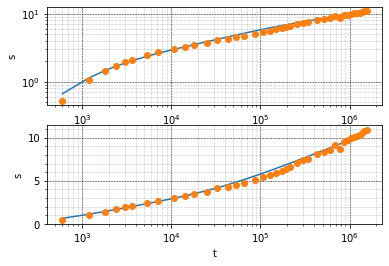

T =  0.0011623637059593906 m2/s
S =  0.002672351562304948 -
Ri =  227.9351449908511 m


In [6]:
model = ht.Theis_noflow(Q=0.0132,r=20, df=df2)
p = model.guess_params()
print("estimated parameter vector:",p)
model.trial()


In [7]:
p = model.fit()
p

`ftol` termination condition is satisfied.
Function evaluations 50, initial cost 1.7005e+00, final cost 7.4091e-01, first-order optimality 1.43e-08.


array([2.45693083e+00, 7.00749816e+02, 1.73581927e+05])

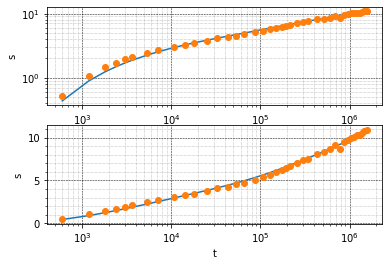

T =  0.0009844345031557308 m2/s
S =  0.0038731875255228814 -
Ri =  314.77537649835 m


In [8]:
model.trial()

`ftol` termination condition is satisfied.
Function evaluations 5, initial cost 7.4091e-01, final cost 7.4091e-01, first-order optimality 1.43e-08.


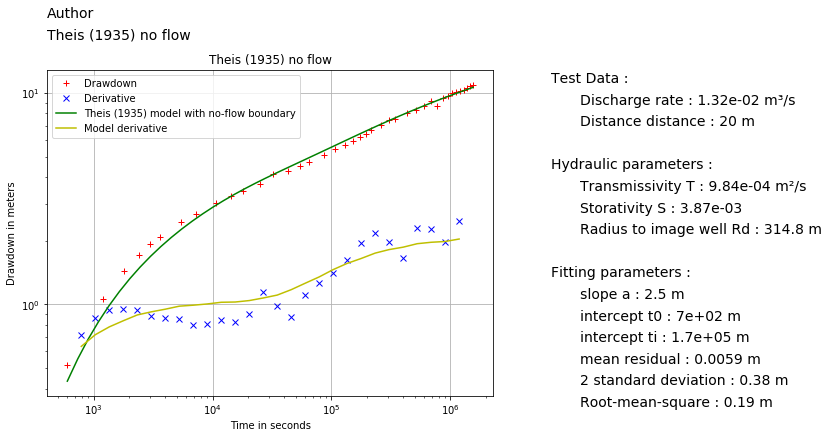

In [9]:
model.rpt()

# Moving to constant head model

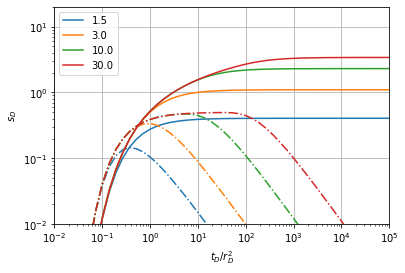

In [27]:
bequer = ht.Theis_constanthead(Rd=33)
bequer.plot_typecurve()

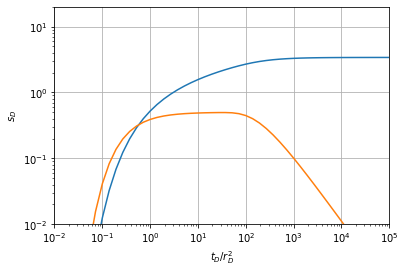

In [28]:
td = np.logspace(-2, 5)
sdn = bequer._laplace_drawdown(td, 'dehoog')
sd = list(sdn)
plt.loglog(td, sd)
ddn = bequer._laplace_drawdown_derivative(td, 'dehoog')
dd = list(ddn)
plt.loglog(td, dd)
plt.xlabel('$t_D / r_D^2$')
plt.ylabel('$s_D$')
plt.xlim((1e-2, 1e5))
plt.ylim((1e-2, 20))
plt.grid('True')

In [29]:
sd2 = bequer.dimensionless(td)
residual = sd-sd2

mr = np.mean(residual) #mean resiudal
print(mr)
sr = 2 * np.std(residual) #standard deviation
print(sr)
rms = np.sqrt(np.mean(residual**2))
print(rms)

3.40518548071755e-12
5.99046610146945e-12
4.5350533829607e-12


In [30]:
dd2 = bequer.dimensionless_logderivative(td)
residual2 = dd-dd2

mr2 = np.mean(residual2) #mean resiudal
print(mr2)
sr2 = 2 * np.std(residual2) #standard deviation
print(sr2)
rms2 = np.sqrt(np.mean(residual2**2))
print(rms2)

2.42330225690761e-13
9.71061712567578e-13
5.4264551107238e-13


estimated parameter vector: [6.22576096e-01 4.76664633e+01 7.62562843e+04]


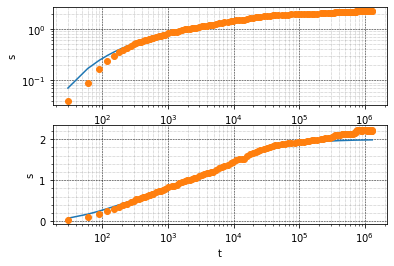

T =  0.008829470041817375 m2/s
S =  0.0023630138786012293 -
Ri =  799.9472518866424 m


In [10]:
bequer = ht.Theis_constanthead(Q=0.030,r=20, df=df3)
p = bequer.guess_params()
print("estimated parameter vector:",p)
bequer.trial()

In [11]:
p = bequer.fit(option='trf')

`ftol` termination condition is satisfied.
Function evaluations 8, initial cost 1.0579e+00, final cost 9.9037e-02, first-order optimality 6.68e-08.


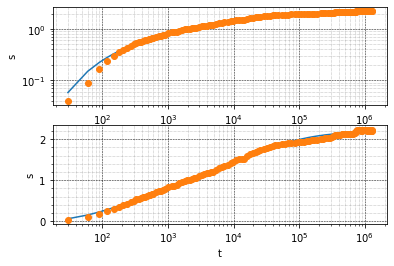

T =  0.008702275255660532 m2/s
S =  0.002656954994692496 -
Ri =  1104.6668793834237 m


In [12]:
bequer.trial()

`ftol` termination condition is satisfied.
Function evaluations 5, initial cost 9.9037e-02, final cost 9.9037e-02, first-order optimality 1.15e-09.


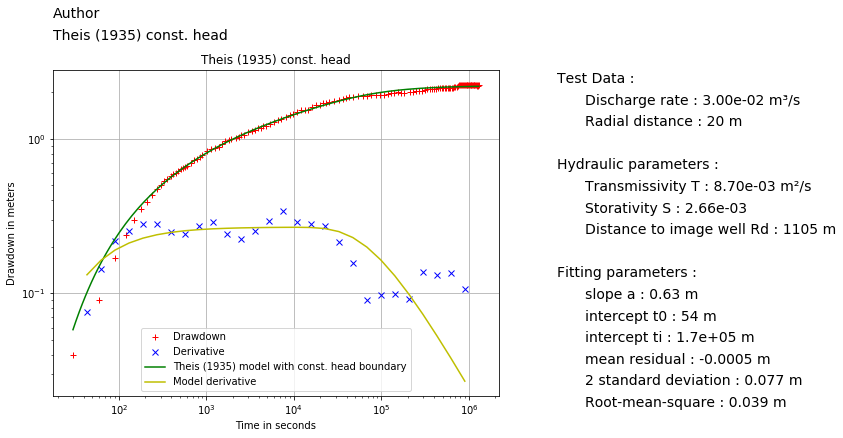

In [13]:
bequer.rpt()

# Cooper-Bredehoeft-Papadopulos (1967) model

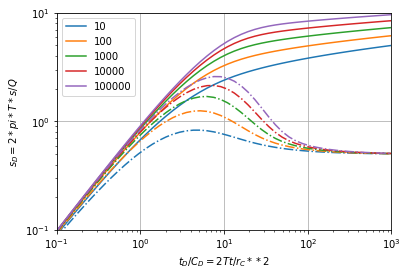

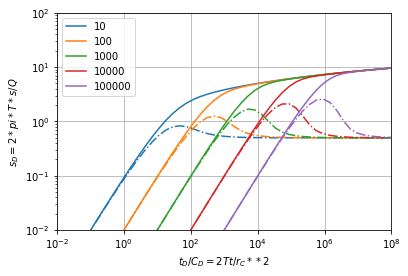

In [35]:
coobredpapa = ht.CooperBredehoeftPapadopulos(r=1, rc=1)
coobredpapa.plot_typecurve()

In [36]:
coobredpapa= ht.CooperBredehoeftPapadopulos(Q=0.0050472, r=3.048, rw=0.6096, rc=0.6096, df=df4)  
p = coobredpapa.guess_params()
print("estimated parameter vector:",p)

estimated parameter vector: [ 1.12133498 12.07038587]


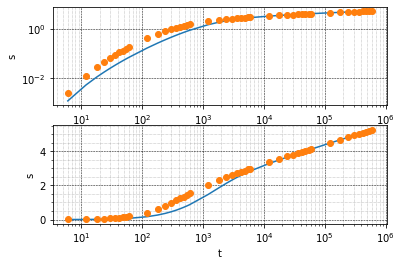

T =  0.0008247474304395393 m2/s
S =  0.0024065278741004052 -
Cd =  207.76821468851975 -


In [37]:
coobredpapa.trial()

`ftol` termination condition is satisfied.
Function evaluations 51, initial cost 1.8137e+00, final cost 7.4911e-01, first-order optimality 3.36e-04.


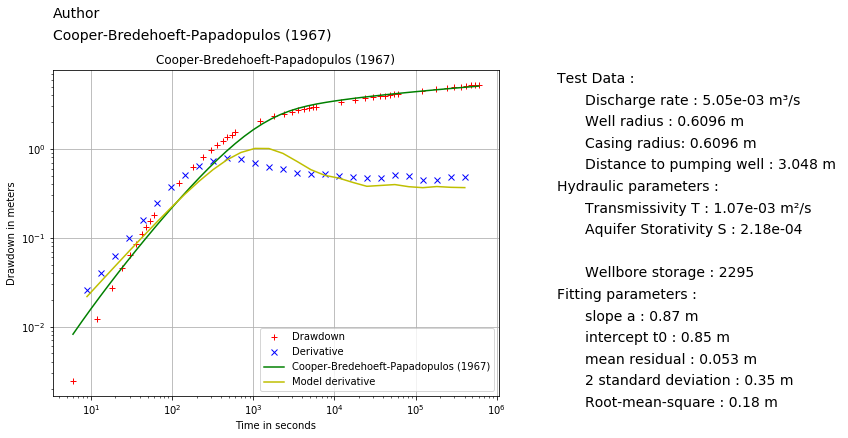

In [38]:
coobredpapa.rpt()

`ftol` termination condition is satisfied.
Function evaluations 28, initial cost 5.6498e-02, final cost 9.0549e-03, first-order optimality 2.03e-06.


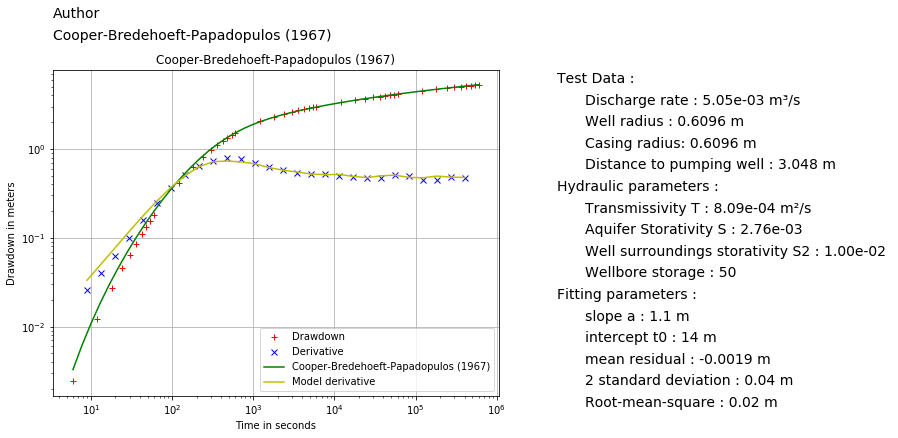

In [39]:
coobredpapa= ht.CooperBredehoeftPapadopulos(Q=0.0050472, r=3.048, rw=0.6096, rc=0.6096, cD=50, df=df4)  
coobredpapa.guess_params()
coobredpapa.rpt()

# Jacob-Lohman (1952) model

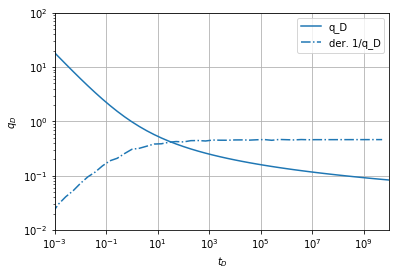

../openhytest/modelclasses.py:1031: RuntimeWarning: divide by zero encountered in true_divide
  q2 = 2 / E1(1, 0.25 / td)
/Users/nathan/opt/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:6717: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


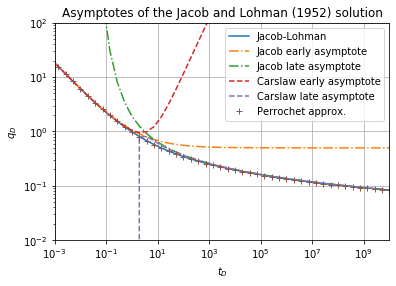

Mean residual between Jacob-Lohman and Perrochet approx.  0.00206916850805667 m^3/s
Standard deviation  0.00265008759640043 m^3/s
Root-mean-square  0.00245707130174977 m^3/s


In [3]:
jcl = ht.JacobLohman(s=28.142, r=0.084, df = df5)
jcl.plot_typecurve()

In [4]:
jcl.guess_params()

array([4.29069293e+02, 2.44768687e-04])

`xtol` termination condition is satisfied.
Function evaluations 53, initial cost 2.4820e-09, final cost 5.6548e-10, first-order optimality 6.41e-10.


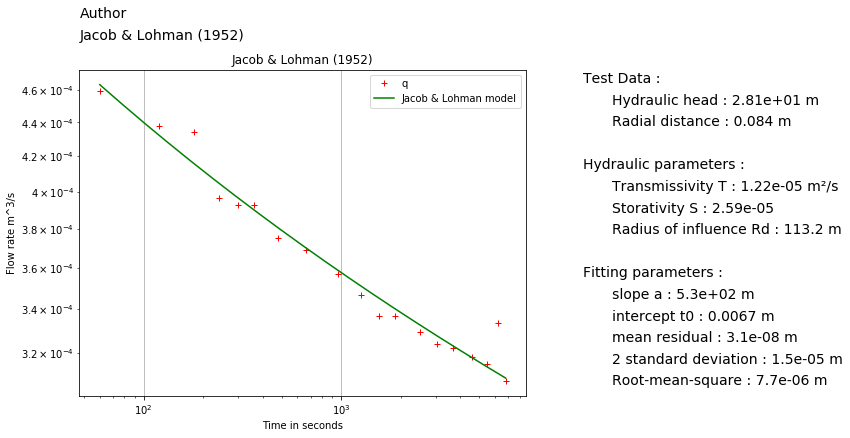

In [5]:
jcl.rpt()

[[1800, 0.005787037037037038], [4800, 0.008101851851851851], [7800, 0.006944444444444444]]


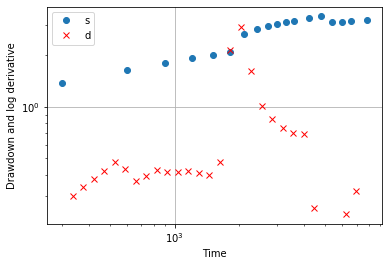

In [14]:
Qmat = [[30*60, 500/3600/24], 
        [80*60, 700/3600/24], 
        [130*60, 600/3600/24]]
print(Qmat)
pro=ht.preprocessing(data=df7, Qmat=Qmat)
pro.diagnostic()
aba = ht.Theis(df=df7)

In [10]:
aba.guess_params()

array([0.57362543, 0.01436084])

## GRF Barker (1988)

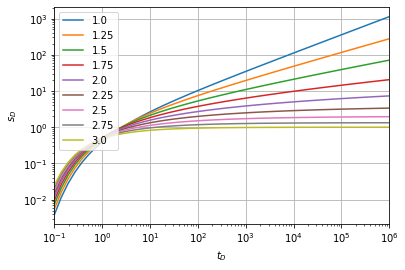

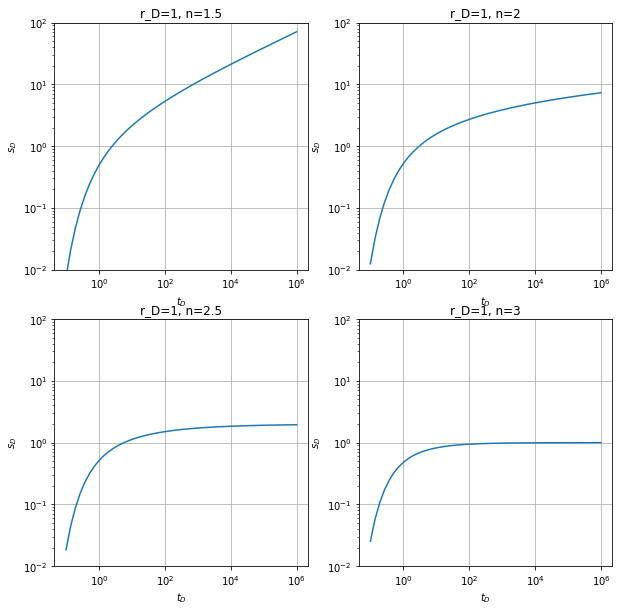

In [3]:
genrad = ht.GRF()
genrad.plot_typecurve()